## Mridula Duggal 
#### Problem Set 7

<h3>Question 1: Solution of the problem without aggregate shocks</h3>

<br/>


<h4>1.1: Household problem</h4>

<br/>


The recursive HH problem is the following:

(1) $V(a,e) = \underset{\{c, a',n\}}{\max{}} log(c) - \Gamma \frac{n^{1+\gamma}}{1+\gamma} + \beta V(a',e')$

s.t.

(2)  $c + a' = wne + (1+r)a$


Plugging the budget constraint into the value function, we end up with an unconstrained problem with 2 controls:

(3) $V(a,e) = \underset{\{a',n\}}{\max{}} log(wne + (1+r)a-a') - \Gamma \frac{n^{1+\gamma}}{1+\gamma} + \beta V(a',e')$

<br/>


**First Order Conditions**

(4) [a']: $\frac{1}{wne + (1+r)a-a'} = \beta V'_{a'}(a',e')$ 

By the Envelope theorem
$V'_{a'} = u'(c')= 1/c' = \frac{(1+r)}{w'n'e' + (1+r)a' -a''}$

Then, we end up with a conventional version of the Euler equation:

(4.1) $\frac{w'n'e' + (1+r)a' -a''}{wne + (1+r)a-a'}= \beta (1+r)$

<br/>


Now, get the intratemporal condition:

(5) [n]: $\frac{we}{wne + (1+r)a-a'}= \Gamma n^\gamma$

From (5) we can recover an expression for n as a function of consumption: 

(5.1.) $n = \big(\frac{we}{\Gamma c}\big)^{1/\gamma}$

<br/>

Plug (5.1.) into the agent's budget constraint:

(6) $c = we\big(\big(\frac{we}{\Gamma c}\big)^{1/\gamma}\big) + (1+r)a -a'$

We cannot isolate analitically c in (6). We have to use a non-linear solver, which is going to give us a function c(a,e,a'). Plugging this function into the value function, we end up with a single control variable: 

(6) $ V(a,e) = \underset{\{a'\}}{\max{}} log(c(a,e,a')) -\Gamma \frac{\big(\big(\frac{we}{\Gamma c(a,e,a')}\big)^{1 + 1/\gamma}\big)}{1+\gamma} + \beta V(a',e')$ 

This is the value function we'll solve below. 

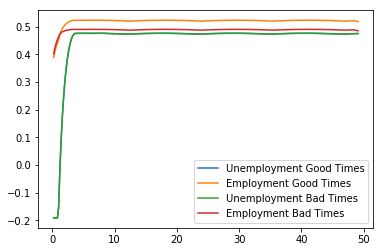

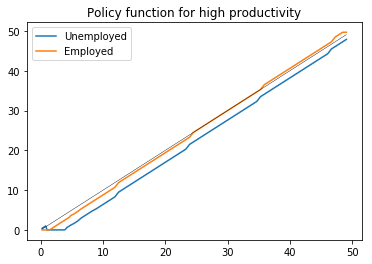

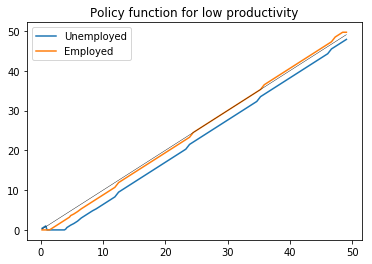

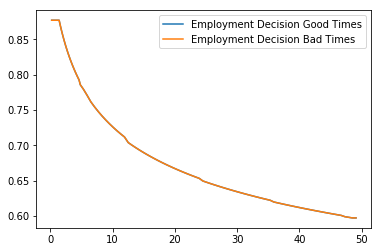

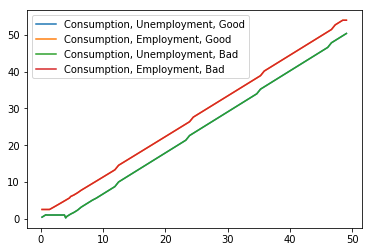

In [36]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from sympy.solvers.solveset import linsolve
import itertools as it
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from scipy.optimize import *
from numpy import *

#Setting parameter values
Γ=2
γ=8
w=1.7512
r=0.0521
e=[0,1]
β=0.99

#Setting the Grid space for assets today, tomorrow and aggregate Capital
k0=np.arange(0,5,0.2)
k1=np.arange(5.3,50,0.6)
k=np.concatenate((k0,k1))
K=np.arange(16,18.5,0.5)

#STEP 1: Computing the utility function for all possible combinations of assets today and tomorrow
#Retrieving the Consumption Matrix using a non-linear solver
C=np.empty((100,100,2))
for i,I,j in it.product(range(100), range(100),range(2)):
    def Ramsey(x):
        c=x[0]
        F=empty((1))
        F[0] = pow(w*e[j], (1+γ/γ))*pow(Γ*c, -1/γ) + (1+r)*k[i] - k[I] -c
        return F

    C[i,I,j]=fsolve(Ramsey,1)

#Utility for consumption 
logC= np.log(C)

#Checing if there are undefined values for utility in consumption
np.isnan(logC)
logC[np.isnan(logC)]=0

#Computing disutility from labour
U_L = (Γ/(1+γ))*pow((w/Γ*C), (1+γ)/γ)
U_L

#Total Utility 
U= logC - U_L

#STEP 2: Initial Guess 
#Define initial functions 
#Bad Times
V0b=np.zeros((100,1))
V1b=np.zeros((100,1))
G0b=np.zeros((100,1))
G1b=np.zeros((100,1))
#Good Times
V0g=np.zeros((100,1))
V1g=np.zeros((100,1))
G0g=np.zeros((100,1))
G1g=np.zeros((100,1))

#STEP 3: Transition matrix
#Good times 
Π_g= [0.86, 0.14,0.1, 0.99]
Π_g=np.reshape(Π_g,[2,2])

#Bad times 
Π_b= [0.79, 0.29,0.03, 0.97]
Π_b=np.reshape(Π_b,[2,2])

#STEP 4: Value Function Iteration - Bad and Good Times
V0bt=np.zeros((100,1))
V1bt=np.zeros((100,1))
V0gt=np.zeros((100,1))
V1gt=np.zeros((100,1))

count = 0
eps=0.00001
Devb=0.5
Devg=0.5
while Devb > eps and Devg > eps: 
    for i in range(99):
        #Bad Times
        V0bt[i]= max(U[i,:,0] + β*((Π_b[0,0]*V0b[i])+ (Π_b[0,1]*V1b[i])))       
        V1bt[i] = max(U[i,:,1] + β*((Π_b[1,0]*V0b[i])+(Π_b[1,1]*V1b[i])))
        G0b[i] = np.argmax(U[i,:,0] + β*((Π_b[0,0]*V0b[i])+ (Π_b[0,1]*V1b[i])))
        G1b[i] = np.argmax(U[i,:,1] + β*((Π_b[1,0]*V0b[i])+(Π_b[1,1]*V1b[i])))
        
        #Bad times
  
        Diff0b=abs(V0bt-V0b)
        dev0b=Diff0b.max()

        Diff1b=abs(V1bt-V1b)
        dev1b=Diff1b.max()

        Devb=max(dev0b, dev1b)
        
        #Good Times
        V0gt[i]= max(U[i,:,0] + β*((Π_g[0,0]*V0g[i])+ (Π_g[0,1]*V1g[i])))       
        V1gt[i] = max(U[i,:,1] + β*((Π_g[1,0]*V0g[i])+(Π_g[1,1]*V1g[i])))
        G0g[i] = np.argmax(U[i,:,0] + β*((Π_g[0,0]*V0b[i])+ (Π_g[0,1]*V1b[i])))
        G1g[i] = np.argmax(U[i,:,1] + β*((Π_g[1,0]*V0b[i])+(Π_g[1,1]*V1b[i])))
        
        #Good Times
        Diff0g=abs(V0gt-V0g)
        dev0g=Diff0g.max()

        Diff1g=abs(V1gt-V1g)
        dev1g=Diff1g.max()

        Devg=max(dev0g, dev1g)

        count+=1

        V0b=V0bt
        V1b=V1bt 
        V0g=V0gt
        V1g=V1gt 
        
plt.plot(k[1:99],V0g[1:99], label="Unemployment Good Times")
plt.plot(k[1:99],V1g[1:99], label="Employment Good Times")
plt.plot(k[1:99],V0b[1:99], label="Unemployment Bad Times")
plt.plot(k[1:99],V1b[1:99], label="Employment Bad Times")
plt.legend()
plt.show()

g0b=np.zeros((100,1))
g1b=np.zeros((100,1))
g0g=np.zeros((100,1))
g1g=np.zeros((100,1))

for i in range(100):
    g0g[i]=k[int(G0g[i])]
    g1g[i]=k[int(G1g[i])]
    g0b[i]=k[int(G0b[i])]
    g1b[i]=k[int(G1b[i])]
    
plt.plot(k[1:99],g0g[1:99], label='Unemployed')
plt.plot(k[1:99],g1g[1:99], label='Employed')
plt.plot(k[1:99],k[1:99], 'k', linewidth=0.4)
plt.legend()
plt.title('Policy function for high productivity')
plt.show()

plt.plot(k[1:99],g0b[1:99], label='Unemployed')
plt.plot(k[1:99],g1b[1:99], label='Employed')
plt.plot(k[1:99],k[1:99], 'k', linewidth=0.4)
plt.title('Policy function for low productivity')
plt.legend()
plt.show()

#Compute the value of Consumption from the Optimal Asset Decisions
C0g=np.empty((100,1))
for i,I in it.product(range(100), range(100)):
    def Ramsey(x):
        c=x[0]
        F=empty((1))
        F[0] = pow(w*e[0], (1+γ/γ))*pow(Γ*c, -1/γ) + (1+r)*g0g[i] - g0g[I] -c
        return F

    C0g[i]=fsolve(Ramsey,1)
    
C1g=np.empty((100,1))
for i,I in it.product(range(100), range(100)):
    def Ramsey(x):
        c=x[0]
        F=empty((1))
        F[0] = pow(w*e[1], (1+γ/γ))*pow(Γ*c, -1/γ) + (1+r)*g1g[i] - g1g[I] -c
        return F

    C1g[i]=fsolve(Ramsey,1)
    
C0b=np.empty((100,1))
for i,I in it.product(range(100), range(100)):
    def Ramsey(x):
        c=x[0]
        F=empty((1))
        F[0] = pow(w*e[0], (1+γ/γ))*pow(Γ*c, -1/γ) + (1+r)*g0b[i] - g0b[I] -c
        return F

    C0b[i]=fsolve(Ramsey,1)
    
C1b=np.empty((100,1))
for i,I in it.product(range(100), range(100)):
    def Ramsey(x):
        c=x[0]
        F=empty((1))
        F[0] = pow(w*e[1], (1+γ/γ))*pow(Γ*c, -1/γ) + (1+r)*g1b[i] - g1b[I] -c
        return F

    C1b[i]=fsolve(Ramsey,1)
    
#Compute Optimal Labour Decisions
N0g=np.empty((100,1))
N1g=np.empty((100,1))
N0b=np.empty((100,1))
N1b=np.empty((100,1))

for i in range(100):
    N0g[i] = pow(((w*e[0])/(Γ*C0g[i])), 1/γ)
    N1g[i] = pow(((w*e[1])/(Γ*C1g[i])), 1/γ)
    N0b[i] = pow(((w*e[0])/(Γ*C0b[i])), 1/γ)
    N1b[i] = pow(((w*e[1])/(Γ*C1b[i])), 1/γ)
    
plt.plot(k[1:99],N1g[1:99], label="Employment Decision Good Times")
plt.plot(k[1:99],N1b[1:99], label="Employment Decision Bad Times")
plt.legend()
plt.show()

#Calculate the Labour Difference for the Good and Bad Times
#diff = [N1g - N1b]
#diff

plt.plot(k[1:99], C0g[1:99], label="Consumption, Unemployment, Good")
plt.plot(k[1:99], C1g[1:99], label="Consumption, Employment, Good")
plt.plot(k[1:99] , C0b[1:99], label="Consumption, Unemployment, Bad")
plt.plot(k[1:99] , C1b[1:99], label="Consumption, Employment, Bad")
plt.legend()
plt.show()

NameError: name 'Π_1' is not defined